# Machine Learning Lab 1
### Eric Johnson & Quincy Schurr

#### Overview
The dataset that we will be using for this lab is called Lahman's Baseball Database. The data is comprised of 24 tables that describe a variety of baseball statistics for players from 1871 through the 2015 season. The four main dataset tables are the Master, Batting, Pitching, and Fielding tables. For much of the analysis, we will be using the Master table and joining them with other tables.

The Master table contains all the demographic data for a player, including their name, playerID, date of birth, hometown, height, and weight. This table originally had 24 features and 19049 rows, for all players in baseball. The requirements for this project say at least 30,000 records, but once the data has been cleaned up and merged it with some of the other tables that we want to draw data from, there will be many more records for each player.

The other three main tables include player statistics for the player for each year that they played including the team that they played for, batting performance, fielding performance, and pitching. Throughout this lab, we have cleaned up the data a bit by dropping columns that we did not want to analyze as they were not a statistic that all players had, or were unecessary for the study.

The purpose of this data set is for fun and for learning. The dataset has been made available so that baseball fans can analyze player performance and so that baseball statisticians can view player performance and look for correlations in the player statistics. This is helpful for baseball teams looking to use their budget to acquire the best players available at the cheapest cost. There is a book, based on a true story about the Oakland Athletic's team, about the team using this same process to gain an advantage over their competition by buying lesser known, high-quality players for cheap. The book is called Moneyball. If there was a correlation or predictive aspect to what we visualized then it could be useful to baseball teams looking to advance their program in order to get more wins.

There are a lot of different statistics that we could analyze with this dataset that would draw some interesting conclusions. We would like to analyze the most common hometown in each country represented by players, average age of players over time, if there is a relationship between the number of trades that a team partakes in during the year and the number of wins, how batting averages have changed over time, the average ERA over time, if there is a correlation between batting and pitching statistics, the correlation (if any) between season batting averages and home runs hit, and some dimensional reduction in order to classify good and bad teams.

Most data missing from the dataset is at the beginning. This is due to less scrutiny of data collection in the late 1800's along with many statistics being added over time. For the majority of our analysis, we drop data pre 1920 because that is when the National and American Leagues were defined and the statistics collecting is well established.

In the data below, there are no imputations, any values that were missing in the data set, were eliminated. The reasoning behind dropping all values that had a null value/missing value were that many of the statistics should not be influenced by an overwhelming number of records with mean values. The statistics in this data set highlight individual player performance and so filling in missing values with the mean would not be representative of the performance of the player that year. It was better to remove the whole record than to insert the mean values.

In [1]:
#import statements
import plotly
import plotly.graph_objs as go
from plotly.tools import FigureFactory as FF
from plotly.graph_objs import ColorBar
import plotly.plotly as py
plotly.offline.init_notebook_mode() # run at the start of every notebook
py.sign_in('qschurr', '926ny2havn')

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline

In [2]:
# bring in table data from github
master = pd.read_csv('https://raw.githubusercontent.com/chadwickbureau/baseballdatabank/master/core/Master.csv')
master.drop(['nameGiven', 'retroID', 'bbrefID', 'deathYear', 'deathMonth', 'deathDay', 'deathCountry', 'deathState', 'deathCity'], axis = 1, inplace=True)
batting = pd.read_csv('https://raw.githubusercontent.com/chadwickbureau/baseballdatabank/master/core/Batting.csv')
batting.drop(['CS', 'IBB', 'HBP', 'SH', 'SF', 'GIDP', 'stint', 'SB'], axis=1, inplace=True)

After importing the first two data sets that will be used, we merged them together and dropped all records that included a null value.

In [3]:
#merge player demographics with batting statistics
baseballdata = master.merge(batting)
#just to clean up the data a bit, still have 83822 records. 
baseballdata.dropna(inplace=True)
#convert to int b/c birth date shouldnt be float. Also converting Runs, etc b/c all whole numbers
floatList = ['birthYear', 'birthMonth', 'birthDay', 'R', 'AB', 'H', '2B', '3B', 'HR', 'RBI', 'BB', 'SO']
for x in floatList:
    baseballdata[x] = baseballdata[x].astype(int)
    #convert all types to intergers instead of floats and ints. 

First, we are going to explore, through geospatial visualization, where the majority of Major League baseball players come from in the United States. The variables in this dataframe are as follows:

birthState - an object containing the abbreviations of the United States.

stateCount - the number (int) of Major League players who were born in the USA. This column was created by running a groupBy function on the baseballdata dataframe.

logCount - these floating point values are the result of applying the natural log function to the stateCount, this was done to help make the map easier to read and understand since there are states with a larger share of players than others.

In [4]:
#group the players by country, then state, then count them
state_group = baseballdata.where(baseballdata.birthCountry == 'USA').groupby(by='birthState').birthState.count().to_frame()
state_group.columns = ['stateCount']
state_group['birthState'] = state_group.index
#take the log of count to evenly distribute 
log_nums = state_group['stateCount']
log_Nums = np.log(log_nums.astype('float64'))
state_group['logCount'] = log_Nums

#convert to string to make sure plotly can read the state codes
for col in state_group.columns:
    state_group[col] = state_group[col].astype(str)
    
#create the choropleth plot    
data = [dict (
        type = 'choropleth',
        autocolorscale = True,
        locations = state_group['birthState'],
        z = state_group['logCount'].astype(float),
        locationmode = 'USA-states',
        text = state_group['birthState'] + '<br>' + 'Player Count: '+ state_group['stateCount'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "Count of Players - Logarithmic Function"))]


layout = dict(
        title = 'Major League Player Hometown',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
    
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='d3-cloropleth-map')

The map above shows how many players come from each state in relation to the others. The color bar on the right hand side represents the logarithmic values of the count of players for each state. This graph includes complete data records from 1871, when these records were first kept. By hovering over a state, users can see the total number of players from each state.

The following code is used to analyze the average age of baseball players over time. The age was caluclated by taking the differnce of yearID and birthYear. Both of these are integer values with yearID representing the season. Based on the plot below, the overall age of players has increased since 1871 with the average of players at 26.5 years. Currently, the average is closer to 29 years old. This may be explained by more players attending college for a few years before being drafted or spending a while longer in the minor league before making it to the majors.

C:\Users\Eric\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



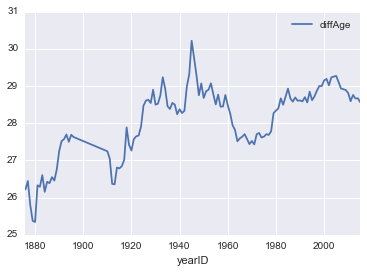

In [5]:
ages = baseballdata[['birthYear', 'yearID']]
ages['diffAge'] = ages['yearID'] - ages['birthYear']
playerAge = ages.groupby(by='yearID')
playerAge_avg = playerAge.mean()
playerAge_avg.plot(y='diffAge')

This next section deals with code that is used to compare the number of trades vs wins during a season. The playerID is an object representing the name of the player and is used as a key between tables. The yearID (int) and teamID (object) signify the the team and season that the player played. The lgID (object) states which leauge the corresponding team was a part of during the season - either National or American League. The 'W' column signifies the number of wins during a season for a certain team. The data is grouped by playerID and year to see if a player played for more than one team during a year. This is equivalent to a trade. We only kept data from 1910 to present because there were a few years between 1875 and 1910 where records were not kept and it caused the graph to look off. After grouping players by the number of teams they played for during a season, the next groupBy function found how many trades there were by a team per season and cross referenced that with the number of wins per season.

In [6]:
bbdata = baseballdata[['playerID', 'yearID', 'teamID']]
#read in team table data
teams = pd.read_csv('https://raw.githubusercontent.com/chadwickbureau/baseballdatabank/master/core/Teams.csv')
teams = teams[['yearID', 'teamID', 'lgID', 'W']]

#merge player data with teams
team_info = teams.merge(bbdata, on=['teamID', 'yearID'])

#group by year and player to see if they played on more than one team for a single season. = trade
traded = team_info.groupby(by=['playerID', 'yearID']).count()
traded = traded.loc[traded['teamID'] > 1] # this contains every player who was traded and what year!
traded.drop(['lgID', 'W'], axis=1, inplace=True)
traded.rename(columns={'teamID' : 'freq'}, inplace=True)
traded['playerID'] = traded.index.get_level_values(0)
traded['yearID'] = traded.index.get_level_values(1)

In [7]:
#now have teams and wins for each players team during a season
match = traded.merge(team_info, on=['playerID','yearID'])
match = match[['playerID', 'yearID', 'teamID','lgID', 'W']]

#to show how many trades occured during the season
season = match.groupby(by=['teamID', 'yearID']).count()
season.rename(columns={'playerID':'numTrades'}, inplace=True)
season['teamID'] = season.index.get_level_values(0)
season['yearID'] = season.index.get_level_values(1)
seasonTrades = season[['teamID', 'yearID', 'numTrades']]

win = team_info[['teamID', 'yearID', 'W']].drop_duplicates()
wins = win.loc[win['yearID'] >= 1910]
tr_win = seasonTrades.merge(wins, on=['teamID', 'yearID'])

In [8]:
#format the output
layout = go.Layout(
    title='Wins vs Number of Trades by Year',
    xaxis=dict(
        title='Year',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='Number of Trades per Season',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    )
)

trace1 = go.Scatter(
    y = tr_win['numTrades'],
    x = tr_win['yearID'],
    mode='markers',
    marker=dict(
        size='14',
        color = tr_win['W'], #set color equal to a variable
        colorscale='Viridis',
        colorbar=ColorBar(
                 title='Season Wins'
        )
    ),
    hoverinfo = 'none'
)

The plot below shows the intersection of season, number of wins, and number of trades. The x axis indicates the year with the y axis indicating the number of trades. The color indicates the number of wins per season. Based on the first graph, there is not much of a correlation, but it can be concluded that there has not been a winning team with a bunch of trades. It can be said that the number of trades does not necessarily help or hurt a team during a season. This first graph cannot give a complete picture though, it would be nice to hover over a point on the graph and see what year and what team the values belong too, however when this was coded, the plotly graph could not load.

In [9]:
fig = go.Figure(data=[trace1], layout=layout)
py.iplot(fig, filename='scatter-plot-with-colorscale')

The graph above is a little crowded and does not give a good story about wins vs trades. The following graph breaks down the same relationship but only for the 2014 baseball season to see if there is a conclusion that can be drawn from the visualizations.

In [10]:
#just want records from 2014
wins2 = wins.loc[win['yearID'] == 2014]
tr_win = seasonTrades.merge(wins2, on=['teamID', 'yearID'])

layout = go.Layout(
    title='2014 Trades vs Wins',
    hovermode='closest',
    xaxis=dict(
        title='Trades',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='Wins',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    )
)

for i in range(len(tr_win)):
    trace0 = go.Scatter(
        y = tr_win['W'],
        x = tr_win['numTrades'],
        mode='markers',
        marker=dict(
            size='12'),
    )

This plot just shows the records for the 30 teams that played during the 2014 season. There is no visible correlation between trades and wins. There are a totaly of 162 games in a regular season and the teams that did partake in more than 10 trades had a winning percentage of about 43%. Then there are teams who traded 5 times and won 43% while another team won almost 60% of their played games. So unless teams are making a lot of trades for the best players out there, it does not benefit a team much to be trading out a lot of their players.

In [11]:
fig = go.Figure(data=[trace0], layout=layout)
py.iplot(fig, filename='scatter-plot')

We want to investigate how long players typically stay in the majors, and how this trend has changed with time. This can easily be done because the date of each player's first and last game is given in the master table.

In [12]:
master = pd.read_csv('https://raw.githubusercontent.com/chadwickbureau/baseballdatabank/master/core/Master.csv')
master.drop(['nameGiven', 'retroID', 'bbrefID', 'deathYear', 'deathMonth', 'deathDay', 'deathCountry', 'deathState', 'deathCity'], axis = 1, inplace=True)
master.dropna(inplace=True)
#Calculate the length of the carrer in days
master['CareerLength'] = pd.to_datetime(master['finalGame']) - pd.to_datetime(master['debut'])
#Convert to an integer for claculating and plotting
master['CareerLength'] = (master['CareerLength'] / np.timedelta64(1, 'D')).astype(int)
print(master.CareerLength.mean() / 365)

5.095042289041177


For all the time that this data has been recorded, the average length of a player's career is just over 5 years. This is surprisingly short. Next we will look at how this trend has changed with time. To do this, we group players together based on the year that they made their debut and take the average length of their careers.

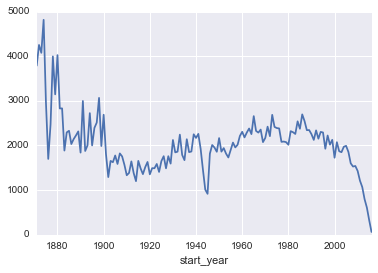

In [13]:
def getYear(row):
    return row.debut.year
    
#Isolate the starting year
master.debut = pd.to_datetime(master.debut, format="%Y-%m-%d")
master['start_year'] = master.apply(getYear, axis=1)

master_grouped_year = master.groupby('start_year')
average_career_with_start_year = master_grouped_year.CareerLength.mean()
average_career_with_start_year.plot()

We see a sharp drop in the average career length from the beginning of the data to roughly 1900. Then the trend is back up. It is interesting to note the dip in career length associated with WWII. Presumably this is because most of the players went off to fight in the war compared to staying and playing baseball. There is also a big drop just after 2002 or so. This is likely due to most players from that start date still being active.

Now we would like to investigate how a player's skill is affected by the amount of time that he is in the league. To do this, we group players together by the number of years that they spent in the league. If increased time in the league is a good inicator of ability, we should see the averages go up for groups of players who have been in the league longer.

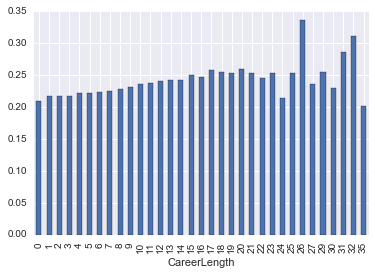

In [14]:
master = pd.read_csv('https://raw.githubusercontent.com/chadwickbureau/baseballdatabank/master/core/Master.csv')
master.drop(['nameGiven', 'birthYear', 'birthMonth', 'birthDay', 'birthCountry', 'birthState', 'birthCity', 'nameFirst', 'nameLast', 'weight', 'height', 'bats', 'throws', 'retroID', 'bbrefID', 'deathYear', 'deathMonth', 'deathDay', 'deathCountry', 'deathState', 'deathCity'], axis = 1, inplace=True)
master.dropna(inplace=True)
#Calculate the length of the carrer in days
master['CareerLength'] = pd.to_datetime(master['finalGame']) - pd.to_datetime(master['debut'])
#Convert to an integer for claculating and plotting
master['CareerLength'] = (master['CareerLength'] / np.timedelta64(365, 'D')).astype(int)

batting = pd.read_csv('https://raw.githubusercontent.com/chadwickbureau/baseballdatabank/master/core/Batting.csv')
batting.drop(['CS', 'yearID', 'teamID', 'lgID', 'G', 'IBB', 'HBP', 'SH', 'SF', 'GIDP', 'stint', 'SB'], axis=1, inplace=True)
batting['BatAvg'] = batting['H'] / batting['AB']
player_df = master.merge(batting)
player_df = player_df[player_df.AB > 20]
player_grouped_career = player_df.groupby('CareerLength').mean()
player_grouped_career.head()
player_grouped_career.BatAvg.plot(kind='bar')


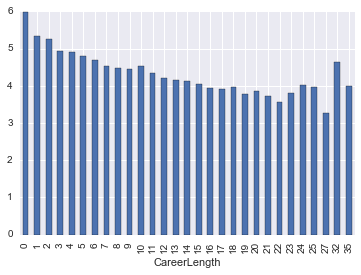

In [15]:
master = pd.read_csv('https://raw.githubusercontent.com/chadwickbureau/baseballdatabank/master/core/Master.csv')
master.drop(['nameGiven', 'birthYear', 'birthMonth', 'birthDay', 'birthCountry', 'birthState', 'birthCity', 'nameFirst', 'nameLast', 'weight', 'height', 'bats', 'throws', 'retroID', 'bbrefID', 'deathYear', 'deathMonth', 'deathDay', 'deathCountry', 'deathState', 'deathCity'], axis = 1, inplace=True)
master.dropna(inplace=True)
#Calculate the length of the carrer in days
master['CareerLength'] = pd.to_datetime(master['finalGame']) - pd.to_datetime(master['debut'])
#Convert to an integer for claculating and plotting
master['CareerLength'] = (master['CareerLength'] / np.timedelta64(365, 'D')).astype(int)

pitching = pd.read_csv('https://raw.githubusercontent.com/chadwickbureau/baseballdatabank/master/core/Pitching.csv')

pitching.drop(['yearID', 'teamID', 'lgID', 'G', 'stint', 'IBB', 'WP', 'HBP', 'BK', 'GF', 'SH', 'SF', 'GIDP', 'BAOpp'], axis=1, inplace=True)
pitching = pitching[pitching.BFP > 20]

player_df = master.merge(pitching)
player_grouped_career = player_df.groupby('CareerLength').mean()
player_grouped_career.head()
player_grouped_career.ERA.plot(kind='bar')

In terms of batting average and ERA we do in fact see a general trend of improvement from players that played longer. There are some deviations from the trend at the upper ends of the career length. This is likely due to a lower number of players making it that far in their career.

We want to see how different important statistics have changed with time. Specifically we will look at batting average and ERA. Changes in batting average either indicate a change in the ability of batters, a change in the quality of defensive play, or likely a combination of the two.

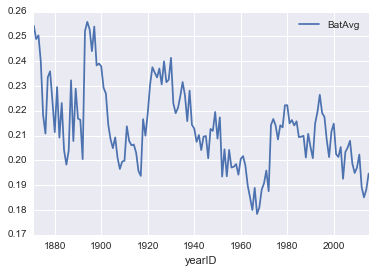

In [16]:
pd.set_option('display.expand_frame_repr', False)
batting = pd.read_csv('https://raw.githubusercontent.com/chadwickbureau/baseballdatabank/master/core/Batting.csv')
batting.drop(['CS', 'IBB', 'HBP', 'SH', 'SF', 'GIDP', 'stint', 'SB'], axis=1, inplace=True)
batting['BatAvg'] = batting['H'] / batting['AB']
batting_grouped_year = batting.groupby(by='yearID')

batting_avg = batting_grouped_year.mean()
batting_std = batting_grouped_year.std()
batting_avg.plot(y='BatAvg')

#print(year_std)

Interestingly, the average batting average across all players for the year has overall gone down, but seems to follow a pattern similar to a sawtooth wave. If the pattern repeats itself, there should be a spike in batting average within the next few years.

Calculating the change in ERA over time is very similar to calculating the change in batting average with time.

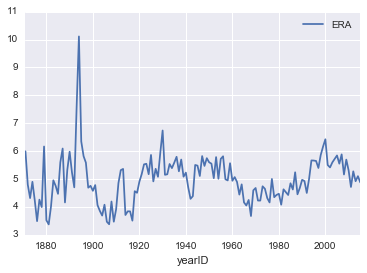

In [17]:
pitching = pd.read_csv('https://raw.githubusercontent.com/chadwickbureau/baseballdatabank/master/core/Pitching.csv')
pitching_grouped_year = pitching.groupby(by='yearID')
pitching_avg = pitching_grouped_year.mean()
pitching_avg.plot(y='ERA')

Apart from a few spikes, ERA has consistantly stayed between 4 and 6. Even though the batting average has fluctuated quite a bit, ERA seems to be much more steady.

We want to see if there is a strong correlation between average ERA and average batting average over the years to determine if one is effecting the other.

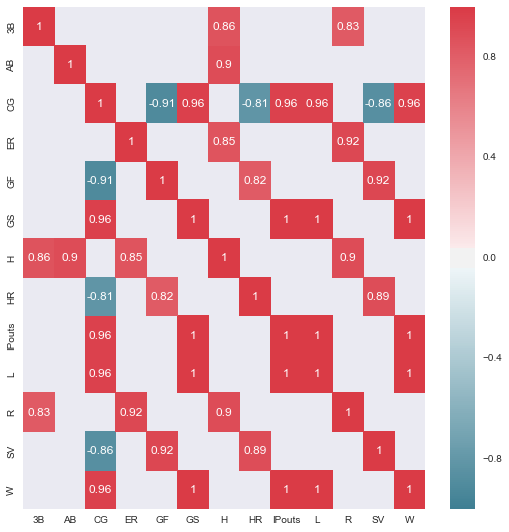

In [18]:
frames = [batting, pitching]
offense_defense_df = pd.concat(frames)
offense_defense_post = offense_defense_df[offense_defense_df.yearID >= 1920].copy()
offense_defense_df.drop(['IBB', 'HBP', 'SH', 'SF', 'GIDP', 'lgID', 'stint', 'teamID', 'playerID', '2B', 'BAOpp', 'BB', 'BFP', 'BK', 'BatAvg', 'ERA', 'G', 'RBI', 'SHO', 'SO', 'WP'], axis=1, inplace=True)
offense_defense_post.drop(['IBB', 'HBP', 'SH', 'SF', 'GIDP', 'lgID', 'stint', 'teamID', 'playerID', '2B', 'BAOpp', 'BB', 'BFP', 'BK', 'G', 'RBI', 'SHO', 'SO', 'WP'], axis=1, inplace=True)

offense_defense_grouped_year = offense_defense_df.groupby(by='yearID')
offense_defense_avg = offense_defense_grouped_year.mean()

offense_defense_grouped_year_post = offense_defense_post.groupby(by='yearID')
offense_defense_avg_post = offense_defense_grouped_year_post.mean()


correlation = offense_defense_avg.corr()
c = correlation[correlation.abs() > .8]

cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.set(style="darkgrid") # one of the many styles to plot using
f, ax = plt.subplots(figsize=(9, 9))
sns.heatmap(c, cmap=cmap, annot=True)

From the plot above, we can see that batting average and ERA do not have a correlation above 0.8. A few interesting correlations are shown in the plot however. Percentage of at bats that are a triple is has relatively high correlation with both runs and hits. The correlation with runs make since as it would seem to indicate when more triples are hit, more runs are scored.

Correlation of Batting Average and ERA before and after 1920 when the National and American leagues were formed. Not much difference. Surprisingly, they are not very correlated.

In [19]:
print (batting_avg['BatAvg'].corr(pitching_avg['ERA']))
print (offense_defense_avg_post.BatAvg.corr(offense_defense_avg_post.ERA))

0.381066164195
0.386066998153


The following code shows season batting averages and the number of home runs hit over time. Both of these numbers are the average percentage per year. It is expected that the percentage of home runs is less than hits, becuase home runs are considered hits as well. It is interesting to see them side by side because there is a definite trend in the number of home runs hit throughout the years, but the batting average has not increased much from year to year. This means that there is not correlation between batting average and home runs.

As seen in the graph above of Batting Average vs Time, there was a very small difference between seasons which is harder to depict in the visualization below due to the x-axis scale. The increase in home runs may be attributed to better bats, playing at higher altitude, or improved techniques among better players. What can be said about the relationship is that since home runs are counted as part of the batting average, they don't necessarily improve overall batting averages of a player, but could be useful in choosing a pinch hitter, or slugger when necessary.

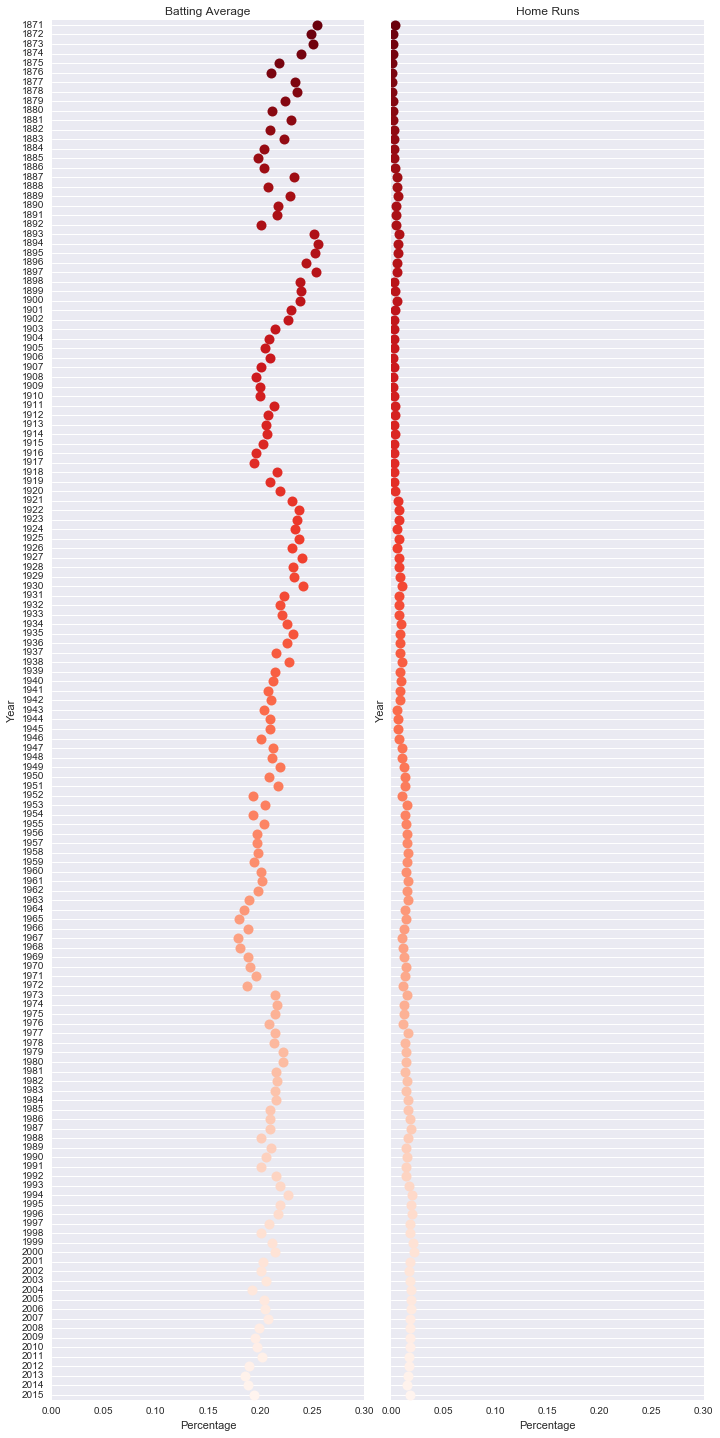

In [20]:
batting1 = batting
batting1.drop(['G','R', '2B', '3B', 'RBI', 'BB', 'SO', 'lgID', 'teamID'], axis=1, inplace=True)
batting1['HRpercent'] = batting1['HR']/batting1['AB'].dropna()

bat_year = batting1.groupby(by='yearID')
bat_avg = bat_year.mean()
bat_avg['yearID'] = bat_avg.index.get_level_values(0)

g = sns.PairGrid(bat_avg.sort_values('AB', ascending=False),
                    x_vars=bat_avg.columns[3:5], y_vars=['yearID'],
                    size=20, aspect=.25)

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=10, orient="h",
      palette="Reds_r", edgecolor="gray")

# Use the same x axis limits on all columns and add better labels
g.set(xlim=(0, .3), xlabel="Percentage", ylabel="Year")

# Use semantically meaningful titles for the columns
titles = ["Batting Average", "Home Runs"]

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

In order to look at how descriptive of the dataset different statistics are, we implement PCA for dimension reduction.

In [21]:
##Determine the number of princpal components needed to represent the majority of batting and pitching data
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
offense_defense_df = pd.concat(frames)
offense_defense_grouped_year = offense_defense_df.groupby(by='yearID')
offense_defense_avg = offense_defense_grouped_year.mean()
#print(batting_avg.info())

def plot_explained_variance(pca):
    import plotly
    from plotly.graph_objs import Scatter, Marker, Layout, XAxis, YAxis, Bar, Line
    plotly.offline.init_notebook_mode() # run at the start of every notebook
    
    explained_var = pca.explained_variance_ratio_
    cum_var_exp = np.cumsum(explained_var)
    
    plotly.offline.iplot({
        "data": [Bar(y=explained_var, name='individual explained variance'),
                 Scatter(y=cum_var_exp, name='cumulative explained variance')
            ],
        "layout": Layout(xaxis=XAxis(title='Principal components'), yaxis=YAxis(title='Explained variance ratio'))
    })

pca = PCA(n_components=11)
batting_avg.dropna(inplace=True)
X_pca=pca.fit(batting_avg)
plot_explained_variance(pca)

##Potentially clean this up
pitching = pd.read_csv('https://raw.githubusercontent.com/chadwickbureau/baseballdatabank/master/core/Pitching.csv')
pitching_grouped_year = pitching.groupby(by='yearID')
pitching_avg = pitching_grouped_year.mean()
pitching_avg.drop(['IBB', 'HBP', 'SH', 'SF', 'GIDP', 'stint', 'WP', 'BAOpp', 'BFP', 'GF'], axis = 1, inplace=True)
pca = PCA(n_components=16)
pitching_avg.dropna(inplace=True)
X_pca=pca.fit(pitching_avg)
plot_explained_variance(pca)

From PCA we can see that for batting, 99% of the variance can be explained with only 4 components. For batting, 99% of the variance can be explained with just 3 components. 

Let's look at the top 2 principal components of pitching and batting data.

In [22]:
pca = PCA(n_components=2)
batting_pca = pca.fit(batting_avg).transform(batting_avg)


print('Batting pca', pca.components_)

Batting pca [[  1.19328439e-01   9.34861598e-01   1.61402415e-01   2.53270556e-01
    3.32034143e-02   2.10088351e-02  -5.55040920e-03   1.18592759e-01
    7.43560086e-02   2.07375686e-02   2.28020952e-04]
 [  6.05338292e-01  -4.07415444e-02  -2.40125677e-01  -1.05417663e-01
    3.52595581e-02  -4.77754362e-02   1.24932672e-01  -1.91855740e-02
    2.67094594e-01   6.87233170e-01  -1.23103484e-03]]


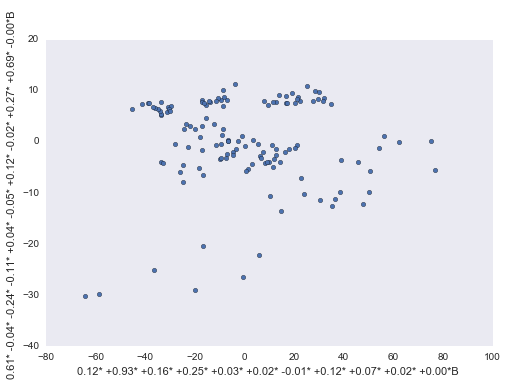

In [23]:
def get_feature_names_from_weights(weights, names):
    tmp_array = []
    for comp in weights:
        tmp_string = ''
        for fidx,f in enumerate(names):
            if fidx>0 and comp[fidx]>=0:
                tmp_string+='+'
            tmp_string += '%.2f*%s ' % (comp[fidx],f[:-5])
        tmp_array.append(tmp_string)
    return tmp_array

pca_weight_strings = get_feature_names_from_weights(pca.components_, batting_avg.columns)

df_pca = pd.DataFrame(batting_pca,columns=[pca_weight_strings])

from pandas.tools.plotting import scatter_plot

# scatter plot the output, with the names created from the weights
ax = scatter_plot(df_pca, pca_weight_strings[0], pca_weight_strings[1])
newfig = plt.figure()
plt.show()


Let's do some classification!! Classes are the quality of batter. We will first look at the data to determine how many classes we think there should be based upon number of clusters from visual inspection. Quality of batter will be on a year to year basis rather than over the course of a players career as that can change drastically.

G         16.773635
AB        16.773635
R         16.773635
H         16.773635
2B        16.773635
3B        16.773635
HR        16.773635
RBI       16.773635
BB        16.773635
SO        16.773635
BatAvg    16.773635
dtype: float64

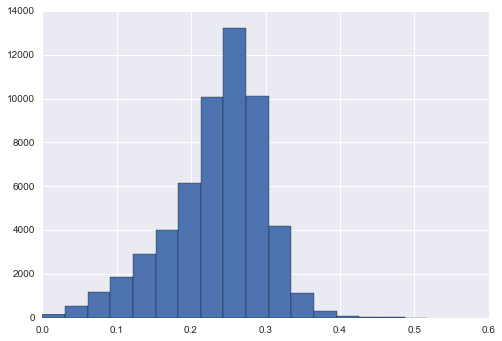

In [24]:
batting = pd.read_csv('https://raw.githubusercontent.com/chadwickbureau/baseballdatabank/master/core/Batting.csv')
batting.drop(['CS', 'IBB', 'HBP', 'SH', 'SF', 'GIDP', 'stint', 'SB', 'playerID', 'lgID', 'yearID', 'teamID'], axis=1, inplace=True)
batting.dropna(inplace=True)
batting['BatAvg'] = batting['H'] / batting['AB']

#Make sure people have enough at bats in a season to have reasonable stats.
batting = batting[batting.AB > 20].copy()
batting.BatAvg.hist(bins=17)

#Sturge's rule
k = 1 + 3.322 * np.log10(batting.count())
k

Sturge's rule suggests 17 bins for looking at the histogram. With this value there appears to be a slight jump arround 0.170 and again around 0.200 and a rapid fall off after 0.300 so we will try these values first as our class boundaries. This may cause over fitting in which case we will need to break classes up based on even count.
Divide the data into training and testing. We will use 80% of the data for training and the remaining 20% for testing our classifier.

In [29]:
def label_batter_type(row):
    if row['BatAvg'] < 0.2:
        return 0
    if row['BatAvg'] >= 0.2 and row['BatAvg'] < 0.3:
        return 1
    if row['BatAvg'] >=0.3:
        return 2
    return 3
batting['Class'] = batting.apply(lambda row: label_batter_type(row), axis = 1)

mask = np.random.rand(len(batting)) < 0.8
training = batting[mask].copy()
testing = batting[~mask].copy()
target = training.Class
#print(training)
training.drop(['Class', 'BatAvg', 'H'], axis = 1, inplace=True)

from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(training, target)
target = testing.Class
testing.drop(['Class', 'BatAvg', 'H'], axis=1, inplace=True)


from sklearn.externals.six import StringIO
with open("batting.dot", 'w') as f:
    f = tree.export_graphviz(clf, feature_names=batting.columns, out_file=f)

from sklearn.metrics import confusion_matrix
confusion_matrix(target, clf.predict(testing))

array([[1721,  848,   92],
       [ 908, 5346,  866],
       [  75,  756,  589]])

Our confusion matrix shows decent performance by the decision tree for the class of poor and average batters, but bad performance for good batters. This may hint at it being very difficult to distinguish a very good batter, at least with the variables we investigated. The attached PDF shows the output of the decision tree. The top few levels mostly deal with number of walks and homeruns. This would indicate that these variables are the most important for distinguishing a poor batter from and average one. This would make some sense because a good batter might be better at knowing when to not swing and chase a wild pitch. Meaning that good batters get walked more often.